# E6. 첫번째 캐글 

#### 프로젝트의 목적 

* 프로젝트의 목적은 주어진 집값에 대한 학습 데이터를 (train data) 가지고 집값 예측 회귀모델을 만드는것이다.    
* 회귀모델의 정확도는 test data의 실제 집값과 회귀모델의 예측 집값의 차이를 RMSE를 통해서 판단할 것이다. 

#### 평가기준 
1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
2. 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

#### 목차
* Step 1. 데이터 이해하기, 시각화하기
* Step 2. 데이터 전처리 
* Step 3. 모델 만들고 평가하기 (하이퍼파리미터 설정하기)
* Step 4. 테스트 데이터 만들기 

### 필요한 모듈 가져오기 

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score

import xgboost 
import lightgbm 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

### Step 1. 데이터 이해하기, 시각화하기 

In [218]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [219]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [220]:
15035+6468

21503

In [221]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [222]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 변수 이해하기

* ID : 집을 구분하는 번호   
* date : 집을 구매한 날짜   
* bedrooms : 침실의 수   
* bathrooms : 화장실의 수 (소숫점으로 돼있다)  
* sqft_living : 주거 공간의 평방 피트(면적)   
* sqft_lot : 부지의 평방 피트(면적)   
* floors : 집의 층 수   
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰) (0/1) - 이진분류    
* view : 집이 얼마나 좋아 보이는지의 정도 (0-4 분류)   
* condition : 집의 전반적인 상태    
* grade : King County grading 시스템 기준으로 매긴 집의 등급   
* sqft_above : 지하실을 제외한 평방 피트(면적)   
* sqft_basement : 지하실의 평방 피트(면적)   
* yr_built : 지어진 년도   
* yr_renovated : 집을 재건축한 년도   
* zipcode : 우편번호   
* lat : 위도   
* long : 경도   
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
* sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

#### Variables' correlation with price 
아래의 코드로 집가격에 correlation이 있는 변수를 순서대로 살펴보면, sqft_living, grade, sqft_above, sqft_living15, bathrooms 등의 순서로 보여진다. 집의 크기, 화장실의 숫자, grade가 correlation이 크다는걸 알 수 있다. 

In [223]:
data_cor_price = data.corr()['price']
data_cor_price.sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
zipcode         -0.051498
Name: price, dtype: float64

#### 값이 궁금한 변수 더 살펴보기
'waterfront values' 는 이진분류이고, view values/grade values도 categorical values이다. 

In [224]:
print('waterfront values: ', pd.unique(data['waterfront']))
print('view values: ', pd.unique(data['view']))
print('yr_renovated values: ', pd.unique(data['yr_renovated']))
print('grade values:', pd.unique(data['grade']))
print('bathrooms:', pd.unique(data['bathrooms']))

waterfront values:  [0 1]
view values:  [0 3 4 2 1]
yr_renovated values:  [   0 2002 1999 1991 1978 2005 2008 2003 1994 1984 1954 2014 2011 1974
 1983 2013 1990 1957 1977 1981 1995 2000 1986 1992 2004 2007 1987 2006
 1985 1971 1945 1979 1997 2010 1969 1948 2009 1970 2015 1989 2001 1968
 2012 1963 1993 1962 1972 1980 1998 1955 1996 1950 1956 1982 1988 1940
 1946 1975 1964 1958 1976 1973 1967 1965 1944]
grade values: [ 7  6  8  9 10 11 12  5  4  3 13  1]
bathrooms: [1.   2.   2.25 1.5  2.5  1.75 3.   2.75 3.25 4.   3.5  0.75 4.75 5.
 4.25 4.5  3.75 5.25 6.   1.25 0.5  5.5  6.75 5.75 0.   8.   7.5  7.75
 6.25]


####  주요 변수 시각화 해보기
* garde: grade가 올라갈수록 집값이 올라간다. 9넘어갈수록 Q1-Q3의 분포가 꽤 커진다. 한 grade에 다양한 집값이 존재한다. outlier 들이 grade 7,8,9,10에 몰려있다. 일단 눈에 띄는 grade 11에 있는 outlier를 제거해준다. 
* sqft_living, sqft_above, sqft_living15, bathrooms: correlation이 큰대도 linear regression line보다 넓게 분포되어 있다. 

<AxesSubplot:xlabel='grade', ylabel='price'>

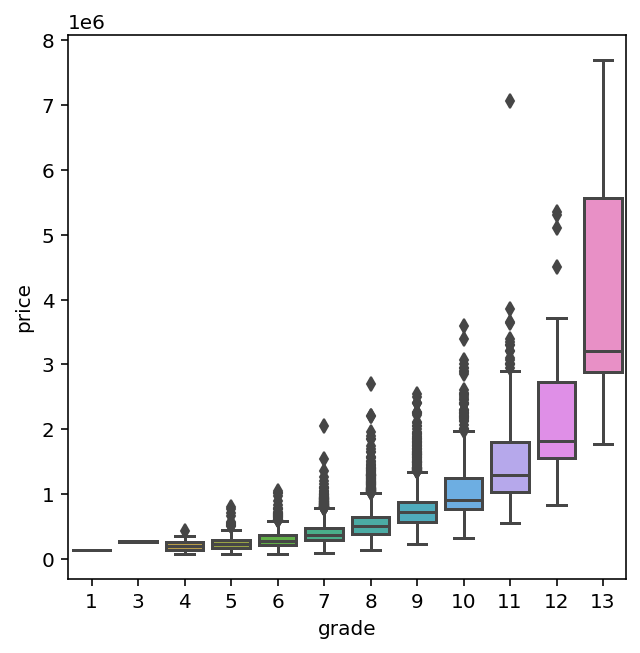

In [225]:
# grade
plt.figure(figsize=(5,5))

sns.boxplot(x='grade', y='price', data=data)

In [226]:
data.loc[data['grade']==11].sort_values(by=['price'],ascending=False)
# id 2775 outlier 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
1499,1499,20141114T000000,3850000.0,4,4.25,5770,21300,2.0,1,4,...,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
4598,4598,20150421T000000,3650000.0,6,4.75,5480,19401,1.5,1,4,...,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
10645,10645,20140911T000000,3640900.0,4,3.25,4830,22257,2.0,1,4,...,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
7297,7297,20150508T000000,3400000.0,4,4.00,4260,11765,2.0,0,0,...,11,3280,980,1939,2010,98112,47.6380,-122.288,4260,10408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4536,4536,20140811T000000,725000.0,3,2.50,3410,41022,2.0,0,0,...,11,3410,0,1990,0,98042,47.3228,-122.080,2150,21429
9849,9849,20140611T000000,657500.0,4,2.75,4140,24190,2.0,0,0,...,11,4140,0,2002,0,98092,47.3062,-122.150,3950,24190
12308,12308,20141219T000000,633000.0,5,2.75,3630,30570,2.0,0,0,...,11,3630,0,2000,0,98058,47.4243,-122.097,3620,41965
943,943,20140523T000000,556000.0,5,2.50,3840,16905,2.0,0,0,...,11,3840,0,1991,0,98023,47.2996,-122.342,3270,12133


In [227]:
data = data[data['id']!=2775]

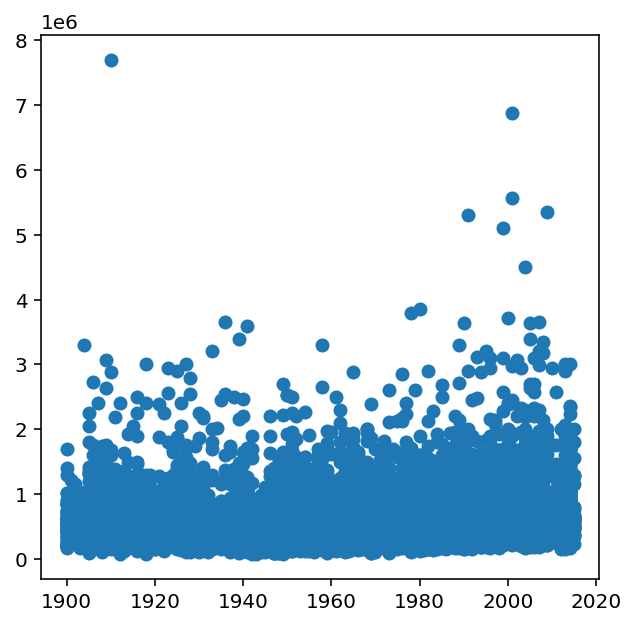

In [228]:
# yr_built correlation 낮았는데, 차트에서 보니깐 outlier 들이 있어서 제거해 준다. 
plt.figure(figsize=(5,5))

plt.scatter(data['yr_built'], data['price'])

In [229]:
data.loc[(data['yr_built']<1920) & (data['yr_built']>1900)].sort_values(by='price', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
12845,12845,20141020T000000,3300000.0,8,4.00,7710,11750,3.5,0,0,...,12,6090,1620,1904,0,98112,47.6263,-122.314,4210,8325
10648,10648,20150212T000000,3065000.0,5,3.00,4150,7500,2.5,0,4,...,11,3510,640,1909,0,98119,47.6303,-122.362,2250,4050
2071,2071,20150202T000000,3000000.0,5,3.25,5370,14091,2.0,0,0,...,10,3850,1520,1918,2008,98004,47.6499,-122.216,2410,12047
9772,9772,20140926T000000,2885000.0,7,3.00,5350,14400,2.5,0,0,...,10,5020,330,1910,0,98112,47.6295,-122.285,3050,7469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,11385,20140703T000000,100000.0,2,0.75,660,5240,1.0,0,0,...,4,660,0,1912,0,98032,47.3881,-122.234,850,5080
10171,10171,20150408T000000,95000.0,2,1.00,960,7000,1.0,0,0,...,4,960,0,1918,0,98198,47.3864,-122.307,1850,8120
5623,5623,20150303T000000,90000.0,1,1.00,780,4000,1.0,0,0,...,5,780,0,1905,0,98108,47.5424,-122.321,1150,4000
12841,12841,20140529T000000,83000.0,2,1.00,900,8580,1.0,0,0,...,5,900,0,1918,0,98168,47.4727,-122.270,2060,6533


In [230]:
data.loc[(data['yr_built']>1995) & (data['yr_built']<2005)].sort_values(by='price', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6469,6469,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
3134,3134,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
842,842,20141020T000000,5110800.0,5,5.25,8010,45517,2.0,1,4,...,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1882,1882,20140815T000000,4500000.0,5,5.50,6640,40014,2.0,1,4,...,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
11364,11364,20140530T000000,3710000.0,4,3.50,5550,28078,2.0,0,2,...,12,3350,2200,2000,0,98039,47.6395,-122.234,2980,19602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10225,10225,20150326T000000,183750.0,3,2.50,1770,3451,2.0,0,0,...,7,1770,0,2004,0,98055,47.4325,-122.197,1490,2138
1532,1532,20141015T000000,180500.0,3,2.50,1800,8518,2.0,0,0,...,7,1800,0,1996,0,98030,47.3643,-122.185,1770,7570
11859,11859,20140522T000000,168000.0,2,2.50,1160,2174,2.0,0,0,...,7,1160,0,1998,0,98106,47.5264,-122.366,1380,1919
14327,14327,20140802T000000,163800.0,2,2.50,1000,1092,2.0,0,0,...,7,990,10,2004,0,98118,47.5419,-122.271,1330,1466


In [231]:
data = data[data['id']!=5108]
data = data[data['id']!=6469]

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

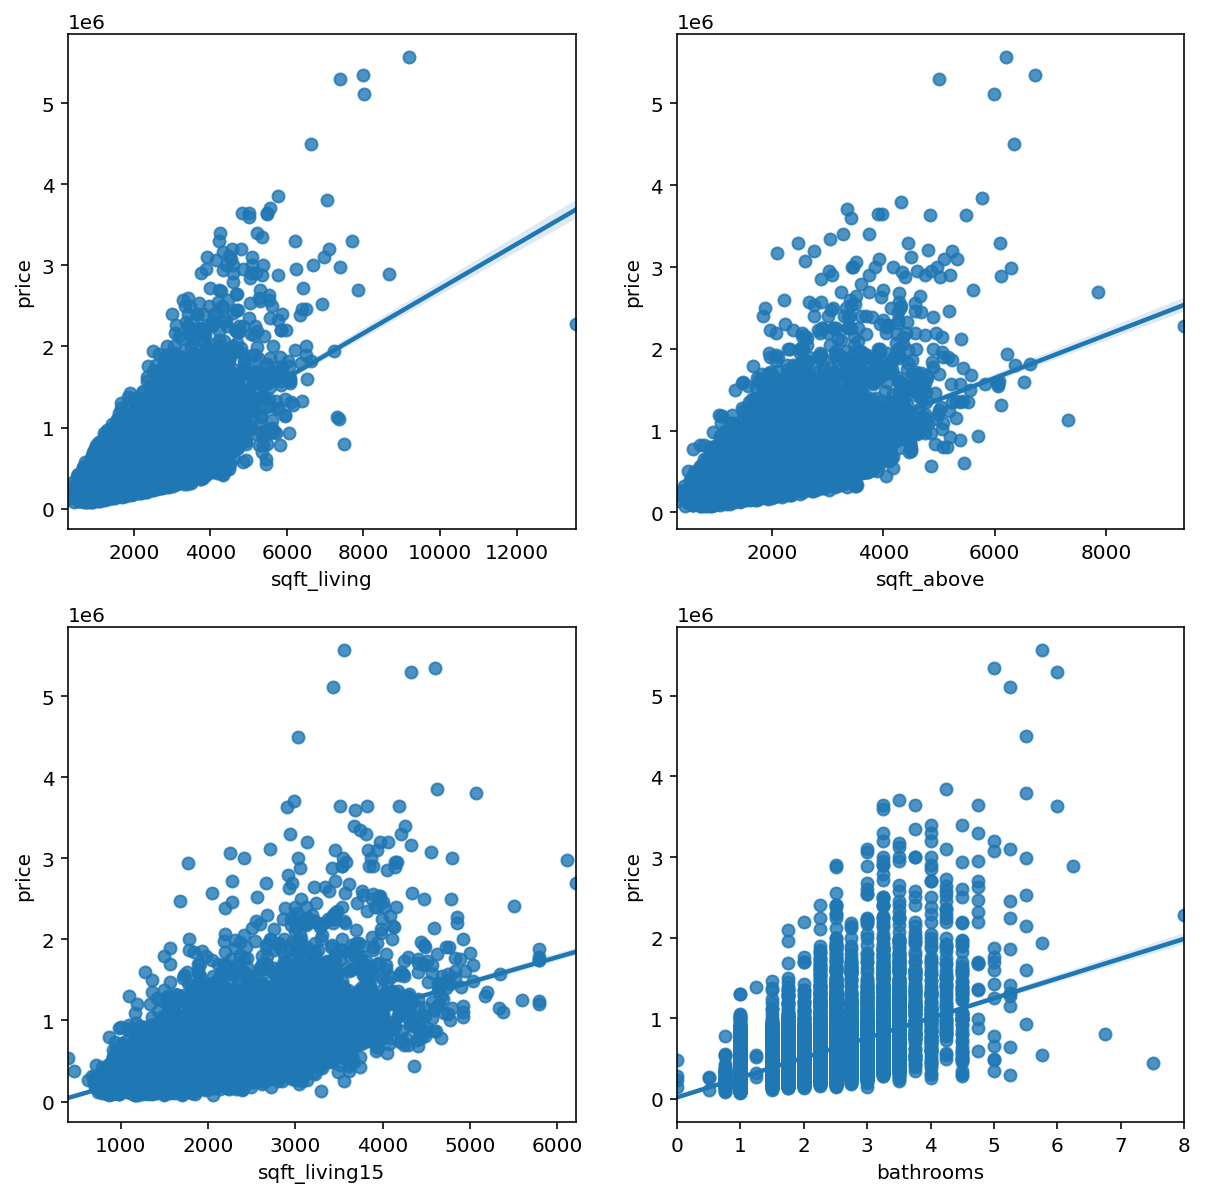

In [232]:
# sqft_living, sqft_above, sqft_living15, bathrooms
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
sns.regplot(x='sqft_living', y='price', data=data)

plt.subplot(2,2,2)
sns.regplot(x='sqft_above', y='price', data=data)

plt.subplot(2,2,3)
sns.regplot(x='sqft_living15', y='price', data=data)

plt.subplot(2,2,4)
sns.regplot(x='bathrooms', y='price', data=data)

In [233]:
# year renovated 1과 0으로 컬럼을 다시 만들어주고 price에 어떤영향이 있는지 시각화 해봄 
data['renovation'] = np.where(data['yr_renovated']==0, 0, 1)
sub['renovation'] = np.where(sub['yr_renovated']==0, 0, 1)

In [234]:
data['renovation'].value_counts()

0    14403
1      629
Name: renovation, dtype: int64

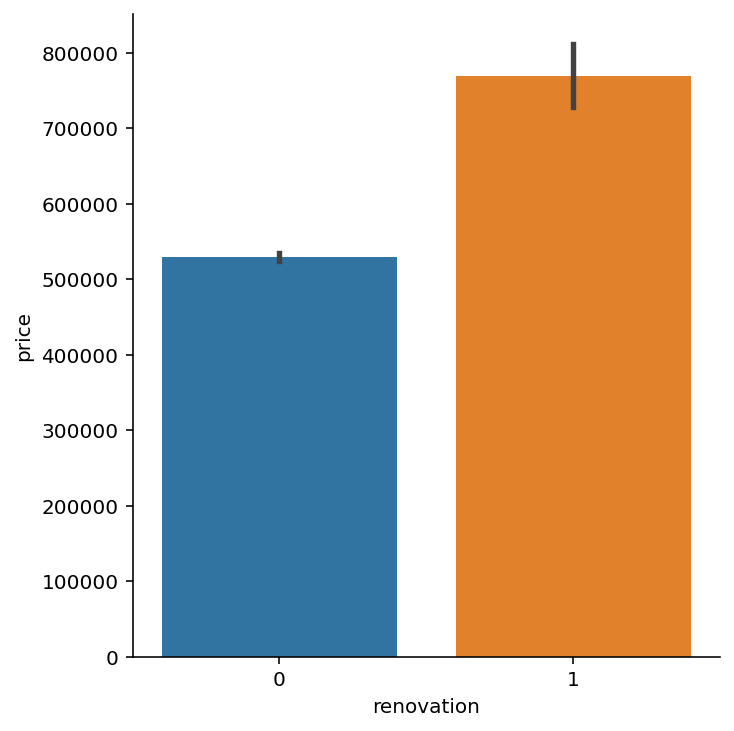

In [235]:
sns.catplot(x='renovation', y='price', data=data, kind='bar')
# 확연하게 가격차이가 난다. 

### Step 2. 데이터 전처리 
1. 데이터 이해하기에서 correlation이 작게 나온 zip code, id, long, cond을 변수에서 제거해 주기로 한다. 
2. 결측치 확인해주기
3. 변수, 타겟의 분포보고 로그변환 취해주기 
4. train, test data 나눠주기 

In [236]:
data_cor_price_update = data.corr()['price']
data_cor_price_update.sort_values(ascending=False)

price            1.000000
sqft_living      0.698212
grade            0.676237
sqft_above       0.603720
sqft_living15    0.595471
bathrooms        0.522916
view             0.401598
bedrooms         0.325414
sqft_basement    0.316732
lat              0.309819
floors           0.266864
waterfront       0.261930
yr_renovated     0.133956
renovation       0.133669
sqft_lot         0.098631
sqft_lot15       0.087698
yr_built         0.051744
condition        0.041373
long             0.025594
id               0.023948
zipcode         -0.051310
Name: price, dtype: float64

In [237]:
y = data['price']
data_prep = data.drop(columns = ['price'])

In [238]:
train_len = len(data)
data_all = pd.concat((data_prep, sub), axis=0) # price 컬럼 미포함

print(len(data_all)) #21503에서 3개 outlier제거. 

21500


In [239]:
data_all = data_all.drop(columns = ['zipcode','id','long','condition'])

<AxesSubplot:>

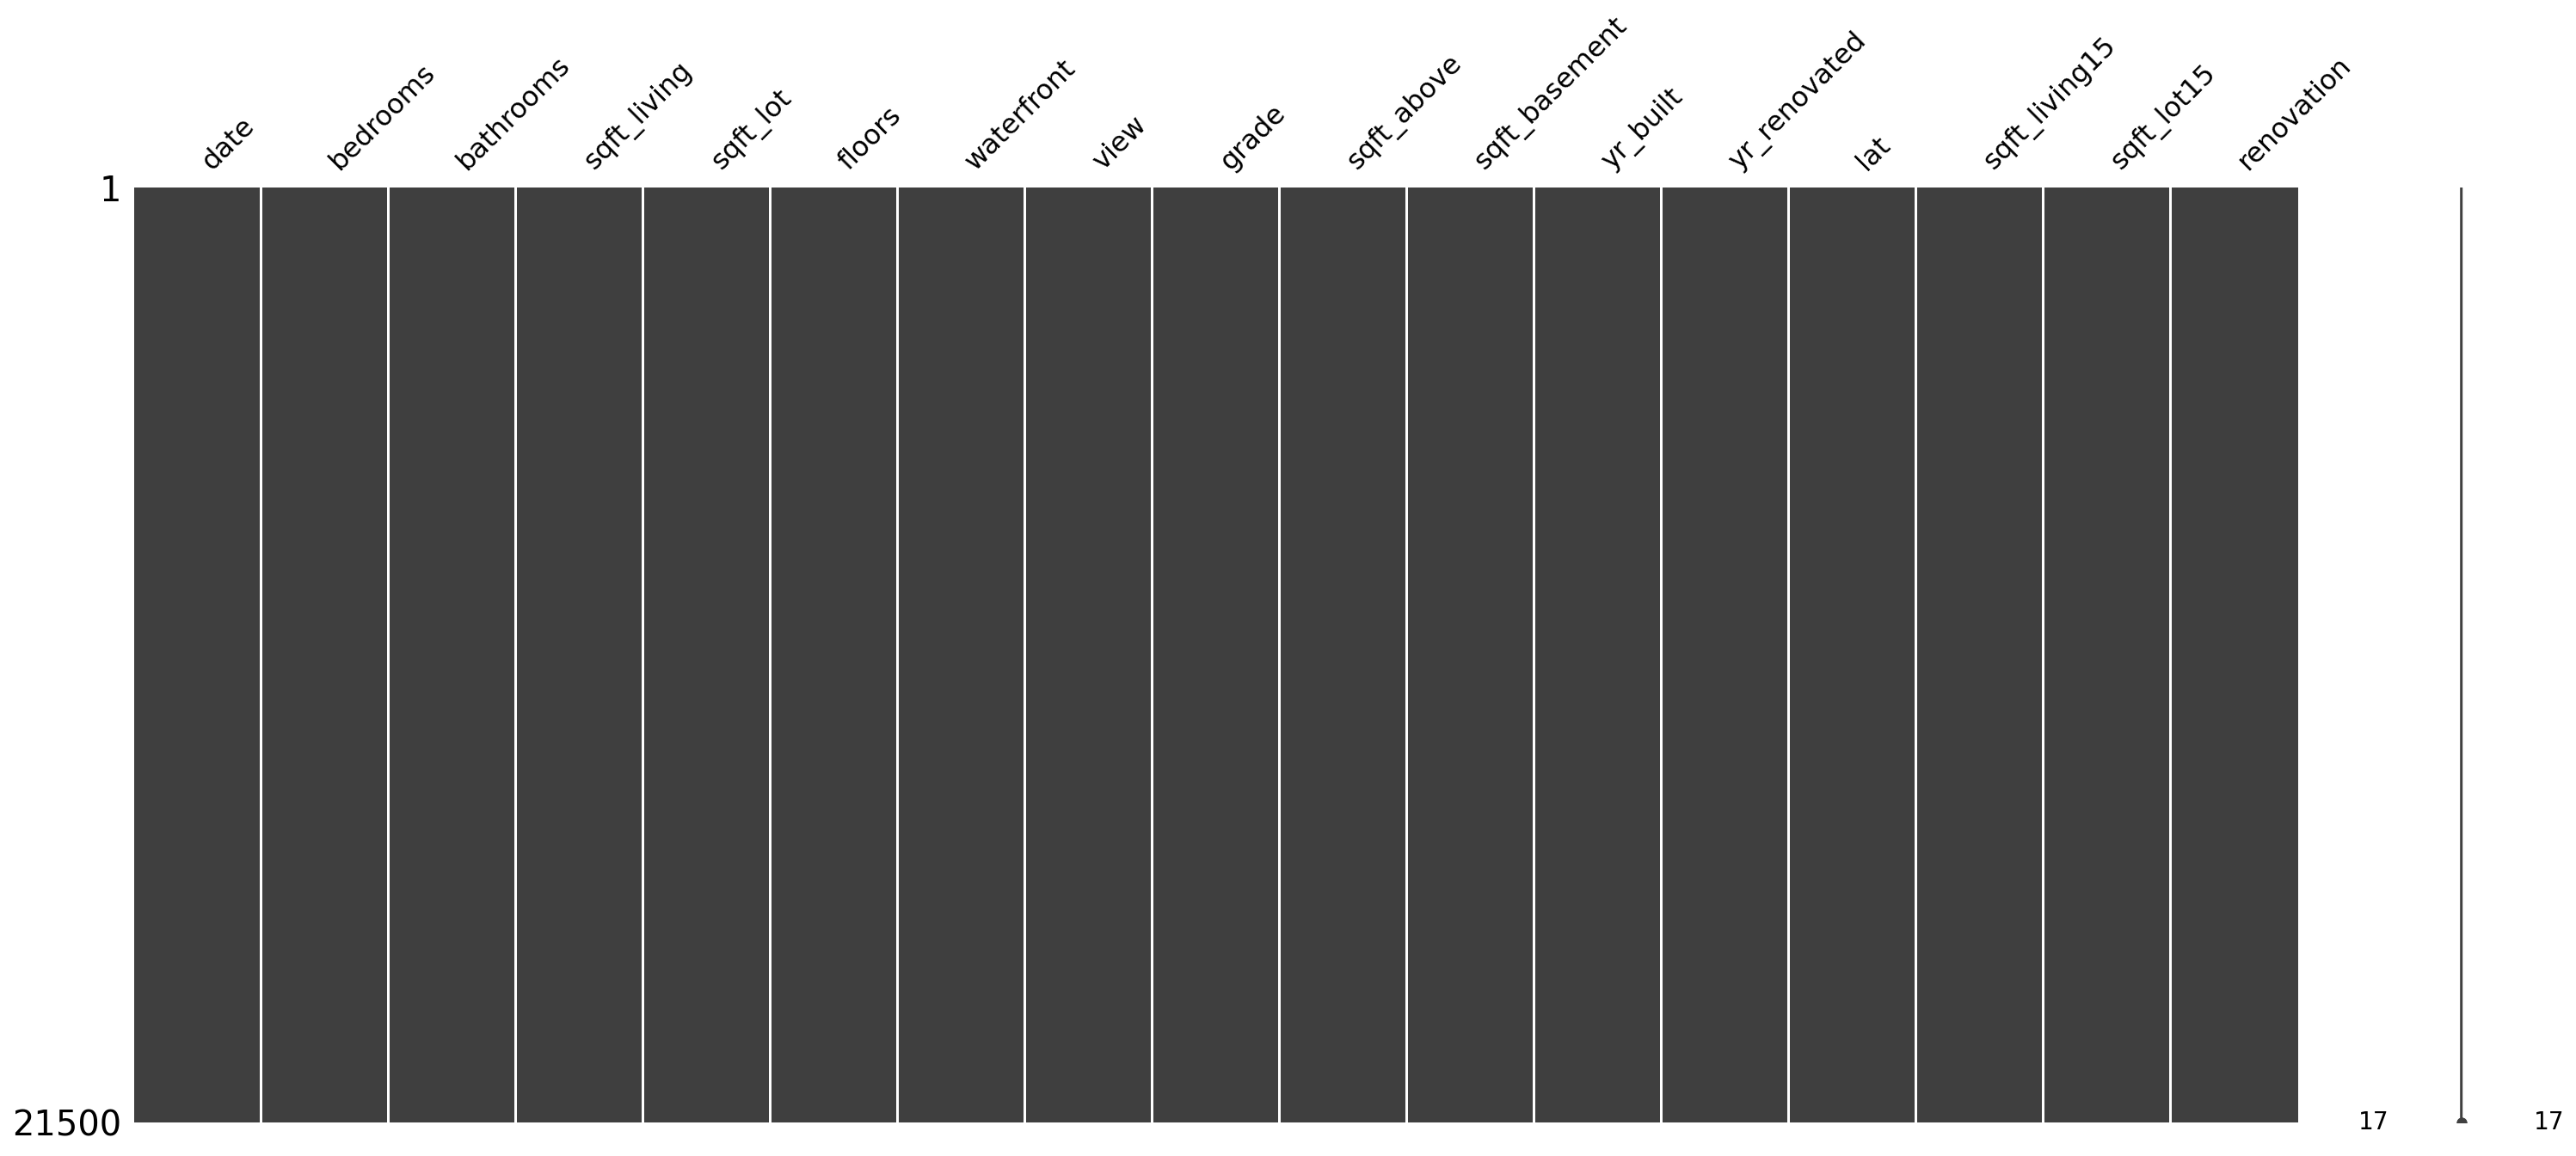

In [240]:
# 결측치 확인 - 결측치 없음

msno.matrix(data_all)

In [241]:
# date 전처리 - year, month 새로운 컬림으로 생성. 

data_all['year'] = data_all['date'].apply(lambda x : str(x[:4])).astype(int)
data_all['month'] = data_all['date'].apply(lambda x : str(x[4:6])).astype(int)
data_all = data_all.drop(columns=['date'])

#### 변수와 타겟(y)의 로그변환
* 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. 
* 변수들의 분포를 그래프를 통해서 살펴보고 집값(y)의 분포도 분포가 치우쳤기 때문에 로그변환을 시켜줍니다. 

In [242]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovation
count,15032.000000,1.503200e+04,15032.000000,15032.000000,15032.000000,1.503200e+04,15032.000000,15032.000000,15032.000000,15032.000000,...,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000,15032.000000
mean,7517.545436,5.393505e+05,3.368680,2.114140,2082.078632,1.529361e+04,1.497938,0.007052,0.233701,3.406666,...,1792.845796,289.232837,1971.104577,83.550359,98078.037653,47.560705,-122.213668,1992.326903,12821.323244,0.041844
std,4340.582856,3.593588e+05,0.902203,0.764465,914.125026,4.261637e+04,0.538482,0.083680,0.762364,0.646534,...,826.586143,439.572433,29.404218,399.831098,53.298403,0.138174,0.141306,690.849940,27737.744312,0.200239
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000
25%,3758.750000,3.219875e+05,3.000000,1.750000,1430.000000,5.027000e+03,1.000000,0.000000,0.000000,3.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472650,-122.328000,1490.000000,5100.000000,0.000000
50%,7518.500000,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,0.000000,3.000000,...,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571850,-122.231000,1850.000000,7608.000000,0.000000
75%,11276.250000,6.450000e+05,4.000000,2.500000,2560.000000,1.068825e+04,2.000000,0.000000,0.000000,4.000000,...,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678325,-122.126000,2360.000000,10075.000000,0.000000
max,15034.000000,5.570000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.000000


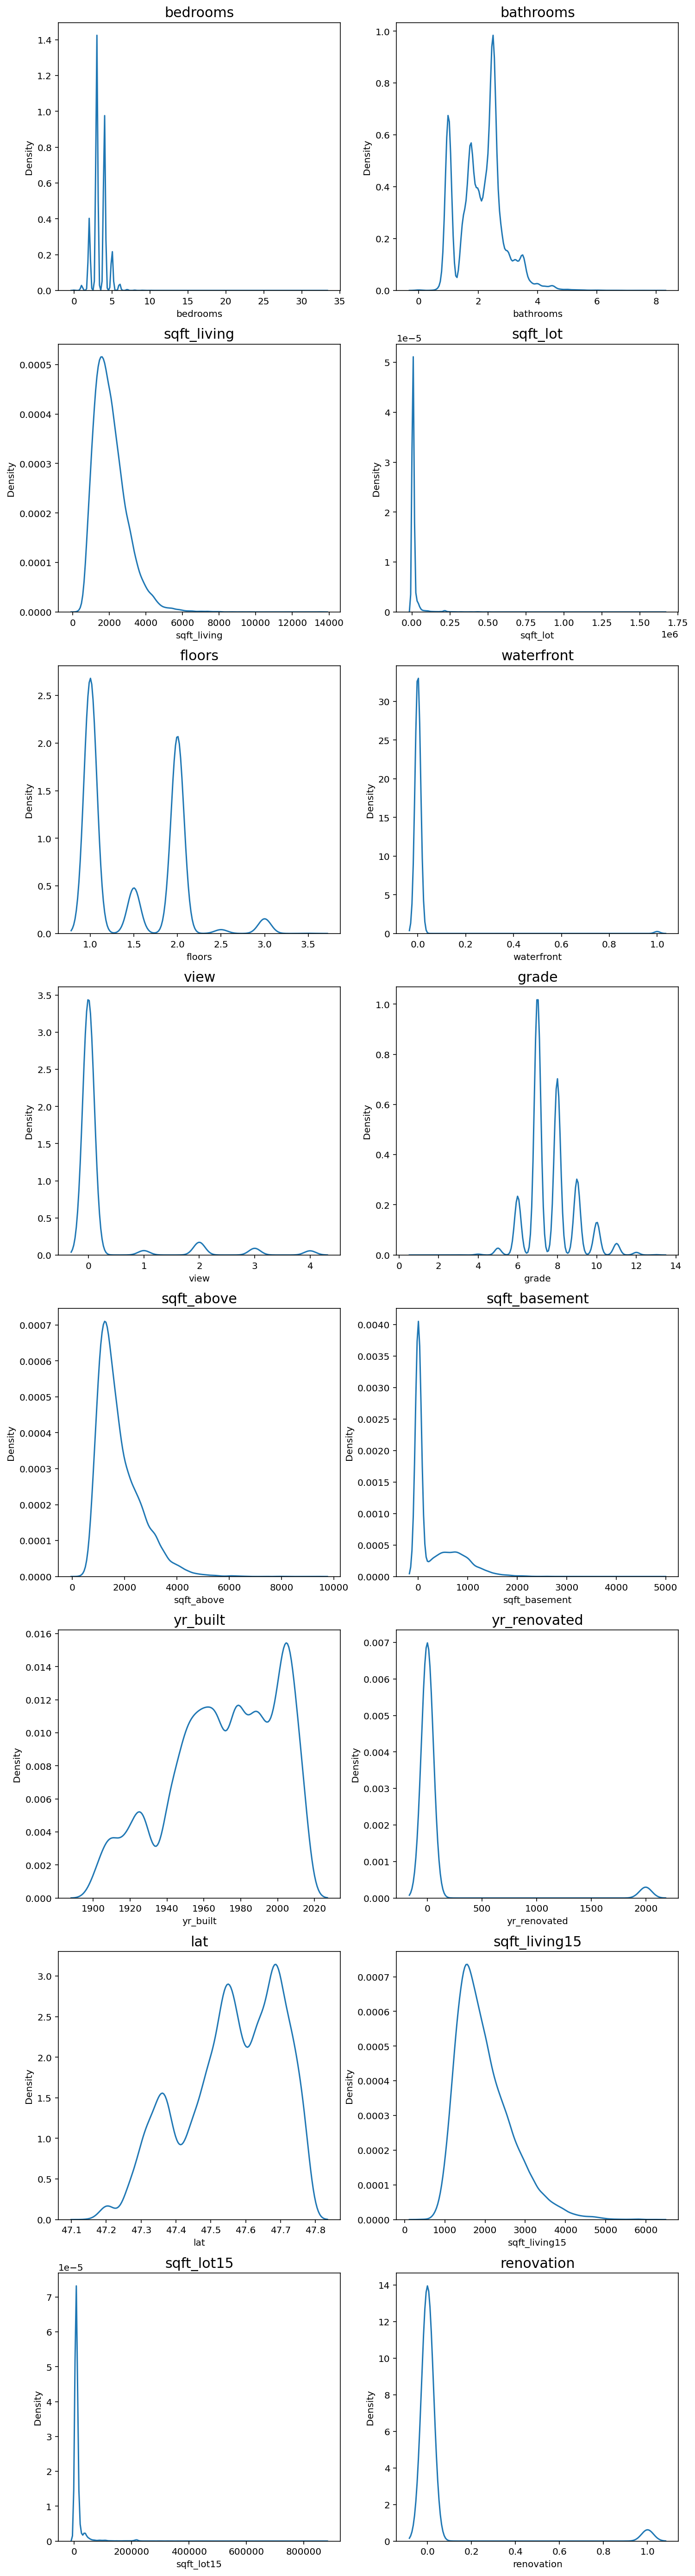

In [174]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   

count = 1
columns = data_all.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data_all[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 17 :
            break

In [175]:
# 로그 변환

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

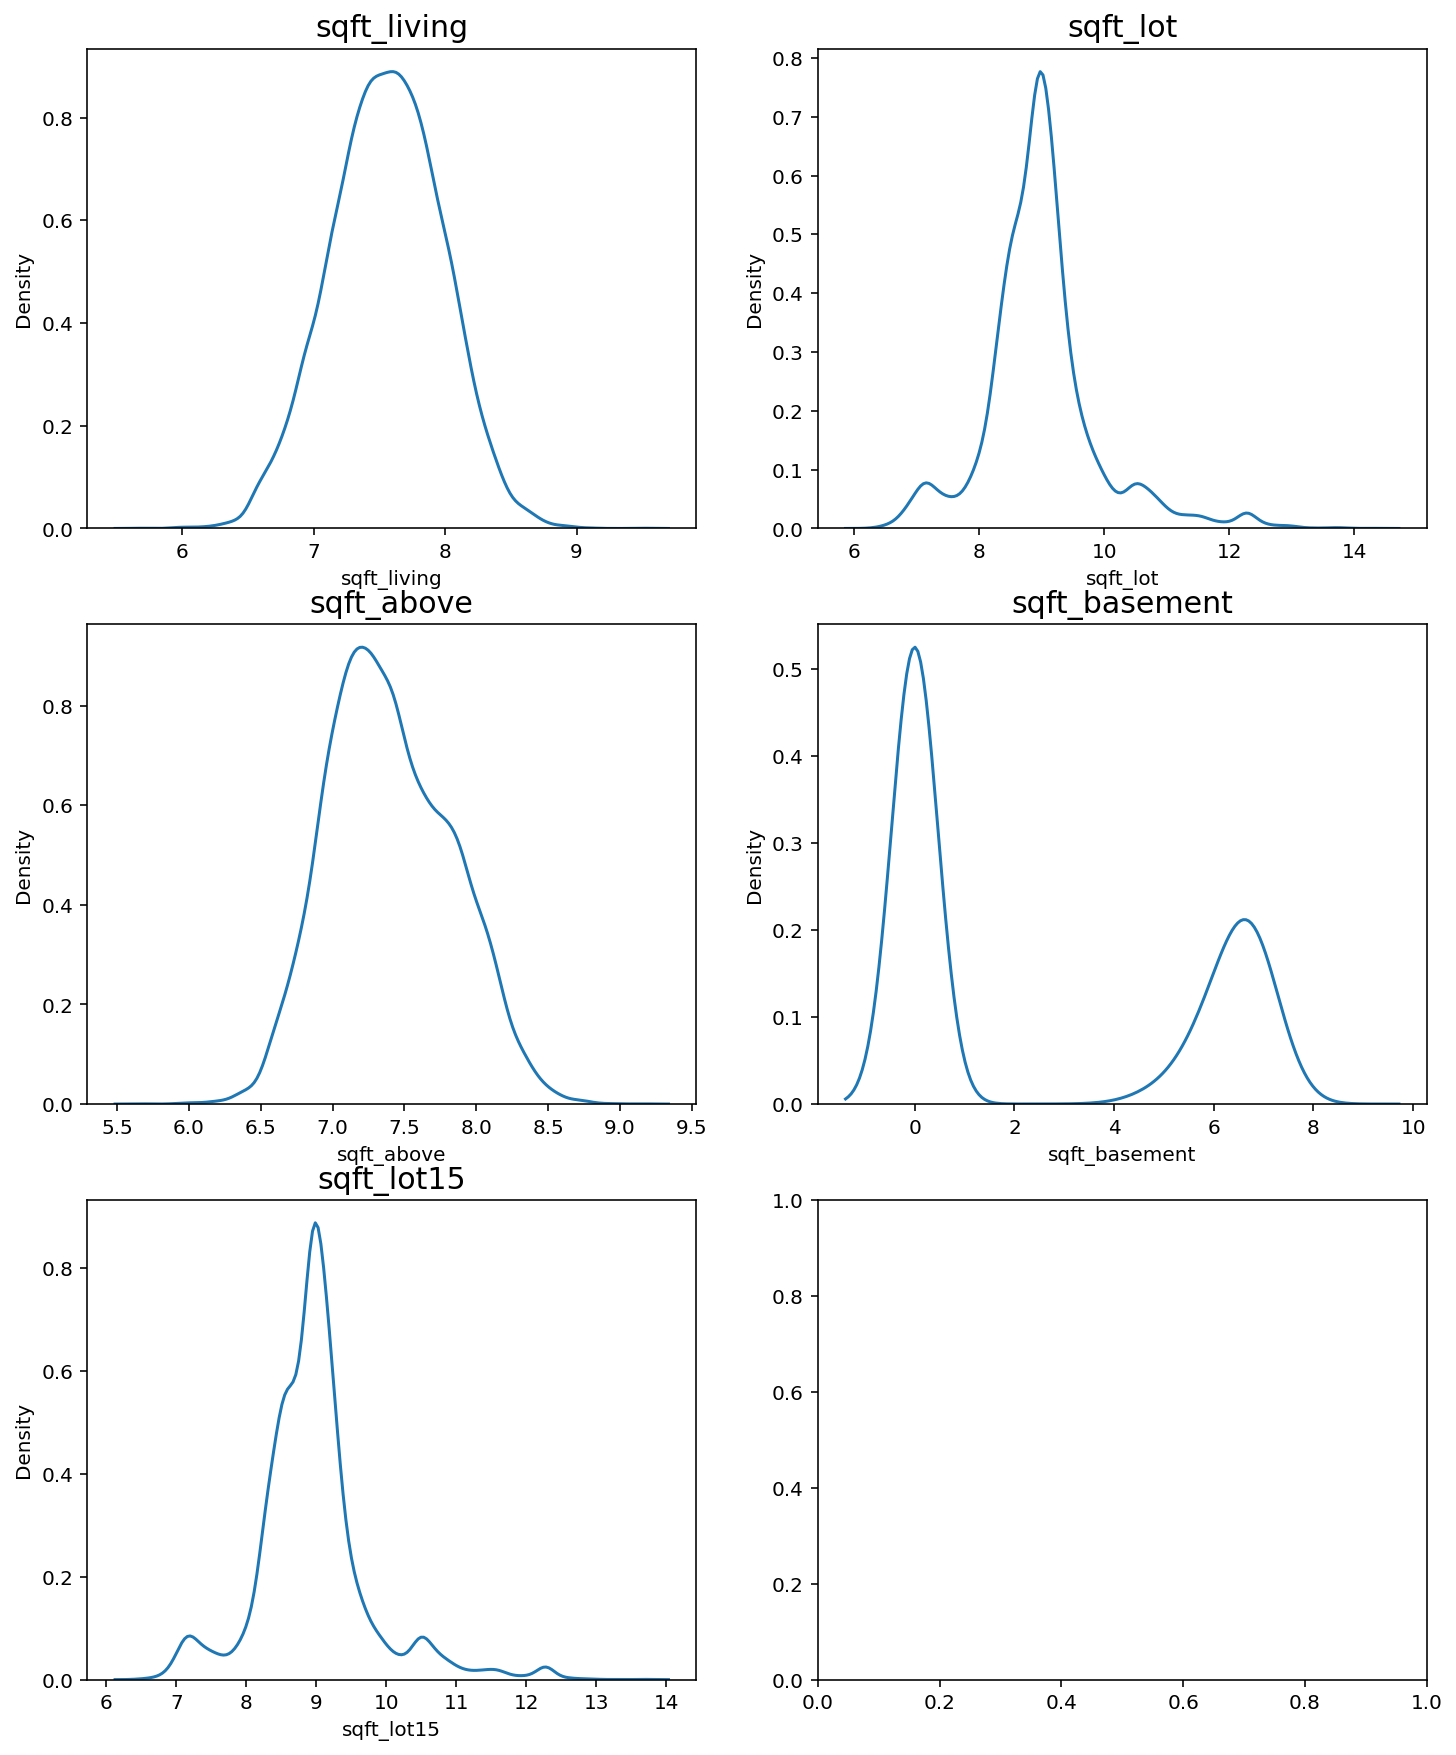

In [176]:
# 변한 변수들의 분포 다시 살펴보기 

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

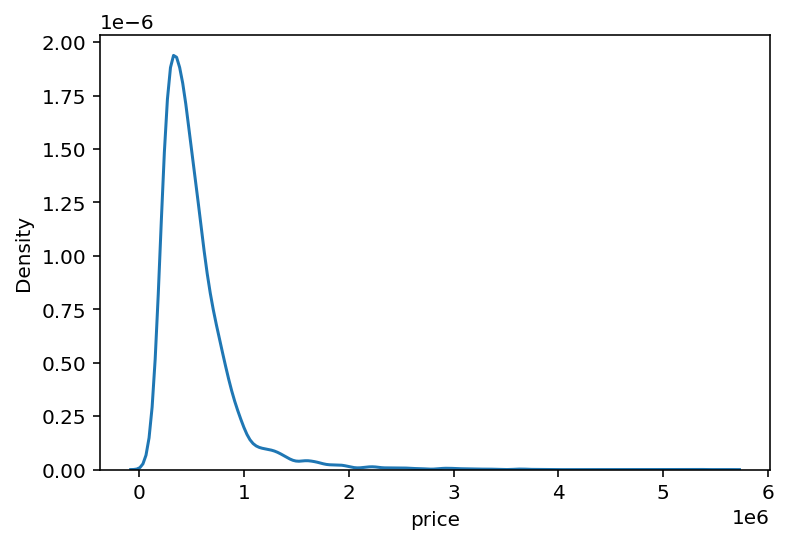

In [177]:
sns.kdeplot(y)
plt.show()

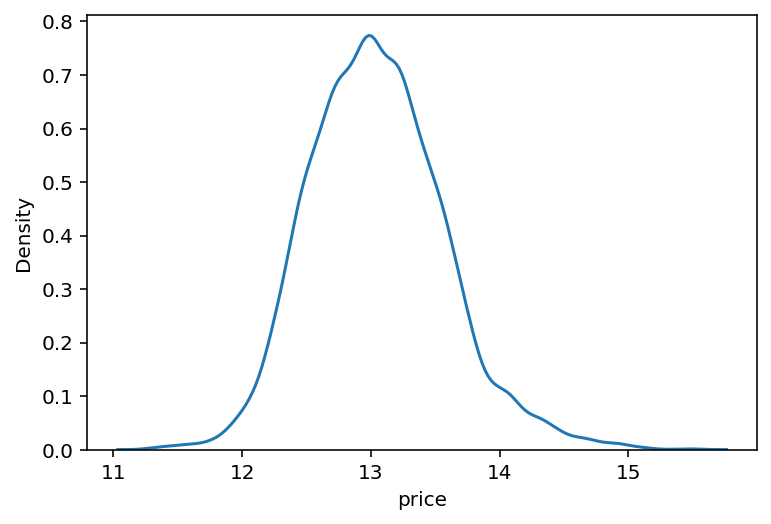

In [257]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

* 전처리가 끝났으므로 다시 train, test 값으로 나누어 준다. 

In [258]:
test = data_all.iloc[train_len:, :]
train = data_all.iloc[:train_len, :]

print(train.shape)
print(test.shape)
print(train.shape[0]+test.shape[0])

(15032, 18)
(6468, 18)
21500


In [259]:
train.dtypes

bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
lat              float64
sqft_living15      int64
sqft_lot15         int64
renovation         int64
year               int64
month              int64
dtype: object

In [260]:
train = train.reset_index(drop=True)

In [261]:
train = train.astype('float32')

In [262]:
train.dtypes

bedrooms         float32
bathrooms        float32
sqft_living      float32
sqft_lot         float32
floors           float32
waterfront       float32
view             float32
grade            float32
sqft_above       float32
sqft_basement    float32
yr_built         float32
yr_renovated     float32
lat              float32
sqft_living15    float32
sqft_lot15       float32
renovation       float32
year             float32
month            float32
dtype: object

### Step 3. 모델 만들고 평가하기

**Four Regression Models for Training**
* Gradient Boosting Regressor: Gradient boosting is a machine learning technique for regression, classification, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.(출처: wikipedia) 
* XGBoosting(Extreme Gradient Boosting) Regressor: XGBoost is one of the most popular versions of the Gradient Boosting Regressor. This does not consider the potential loss for all possible splits to create a new branch. XGBoost tackles this inefficiency by looking at the distribution of features across all data points in a leaf and using this information to reduce the search space of possible feature splits. (출처: https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5) 
* LGBM Regressor: Light GBM is a gradient boosting framework that uses tree based learning algorithm. Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. This method is popurlar because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development. (출처: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) 
* Random Forest Regressor: This is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For regression tasks, the mean or average prediction of the individual trees is returned. (출처: 위키피디아)


#### RMSE 정의

In [263]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 모델 

In [267]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 

random_state=2020    

gboost = GradientBoostingRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state) # hyperparameter
lightgbm = LGBMRegressor(random_state=random_state) # hyperparameter

models=[gboost, rdforest, xgboost, lightgbm]

In [268]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


In [269]:
get_scores(models, train, y)

,RMSE
RandomForestRegressor,148654.839082
GradientBoostingRegressor,146944.454833
XGBRegressor,143732.087582
LGBMRegressor,133240.623589


#### Lightgbm Hyperparameters 

**Parameter tuning know-how** 
Following set of practices can be used to improve your model efficiency.
* num_leaves: This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.
* min_data_in_leaf: Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
* max_depth: You also can use max_depth to limit the tree depth explicitly.

**For better accuracy:**
* Use large max_bin (may be slower)
* Use small learning_rate with large num_iterations
* Use large num_leaves(may cause over-fitting)
* Try to use categorical feature directly

(출처: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같다. 
* max_depth : 의사 결정 나무의 깊이, 정수 사용. overfitting 견제.    
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용   
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수

In [273]:
param_grid = {
    'learning_rate': [0.001, 0.01],
     'max_depth': [5, 10],
    'num_leaves':[32, 512],
'min_data_in_leaf':[500, 1000]}


In [278]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [280]:
grid_result = my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   14.3s finished


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


In [281]:
grid_result

,learning_rate,max_depth,min_data_in_leaf,num_leaves,score,RMSLE
12,0.010,10,500,32,-0.092073,0.303435
13,0.010,10,500,512,-0.092073,0.303435
8,0.010,5,500,32,-0.093011,0.304977
9,0.010,5,500,512,-0.093011,0.304977
14,0.010,10,1000,32,-0.103423,0.321594
15,0.010,10,1000,512,-0.103423,0.321594
10,0.010,5,1000,32,-0.103436,0.321615
11,0.010,5,1000,512,-0.103436,0.321615
4,0.001,10,500,32,-0.240532,0.490440
5,0.001,10,500,512,-0.240532,0.490440


In [282]:
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [286]:
lightgbm_v1 = LGBMRegressor(max_depth=10, learning_rate=0.01, min_data_in_leaf=500, num_leaves=512, random_state=random_state)
lightgbm_v1.fit(X_train, y_train)
pred_v1 = lightgbm_v1.predict(X_test)
rmse(y_test, pred_v1)
# 하이퍼 파리미터를 넣은 rmse 값이 하이퍼파라미터를 튜닝하지 않은것 보다 높게 나왔다. 그러므로 그리드 서치로 찾은 값은 써주지 않았다. 

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


261343.40204821248

In [289]:
xgboost_v1 = XGBRegressor(learning_rate=0.1, random_state=random_state, n_estimators=200, 
                      max_depth =10)
xgboost_v1.fit(X_train, y_train)
xgb_pred_v1 = xgboost_v1.predict(X_test)
rmse(y_test, xgb_pred_v1)

138711.96201930047

### Step 4. 테스트 데이터 만들기

In [290]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [292]:
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,sqft_living15,sqft_lot15,renovation,year,month,price
0,3,2.25,2570,7242,2.0,0,0,7,2170,400,1951,1991,47.7210,1690,7639,1,2014,12,13.171992
1,4,3.00,1960,5000,1.0,0,0,7,1050,910,1965,0,47.5208,1360,5000,0,2014,12,12.716903
2,4,4.50,5420,101930,1.0,0,0,11,3890,1530,2001,0,47.6561,4760,101930,0,2014,5,14.105609
3,3,1.00,1780,7470,1.0,0,0,7,1050,730,1960,0,47.5123,1780,8113,0,2015,4,12.734923
4,3,2.50,1890,6560,2.0,0,0,7,1890,0,2003,0,47.3684,2390,7570,0,2015,3,12.612257


In [291]:
preds1_test = lightgbm.predict(test)
preds2_test = xgboost_v1.predict(test)

test['price'] = 0.5*preds1_test+0.5*preds2_test
submission['price']  = np.expm1(test['price']).clip(lower=0.) # 로그 풀어줌 


,id,price
0,15035,5.254395e+05
1,15036,3.333338e+05
2,15037,1.336558e+06
3,15038,3.393951e+05
4,15039,3.002149e+05


In [296]:
data_dir_submission = os.getenv('HOME')+'/aiffel/Exploration/E6'
my_submission_path = join(data_dir_submission, 'submission.csv')
submission.to_csv(my_submission_path, index=False)